In [256]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import scienceplots

from scipy.interpolate import interp1d
from scipy.differentiate import derivative
from scipy.optimize import root_scalar

import multiprocessing
from multiprocessing import Pool

plt.style.use(['science'])

In [257]:
# top-level callable class — picklable by multiprocessing
class MassDerivative:
    def __init__(self, m_callable):
        # m_callable should be an interp1d-like object
        self.m = m_callable

    def __call__(self, tau):
        return derivative(self.m, tau, maxiter=2, order=3).df

In [258]:
data = pd.read_csv('mt_boson_list.csv', header=None) #boson star mass profile
data.iloc[:, 1] = data.iloc[:, 1].astype(str).str.replace(r'\*\^', 'e', regex=True).astype(float)

#Interpolate the boson star (BS) mass profile:
def m_boson(data, tau_m):
    mtau_cop = data.copy()
    
    # Scale tau values by tau_m
    mtau_cop.iloc[:, 0] = tau_m * mtau_cop.iloc[:, 0]

    # Extract columns
    tau_pos = mtau_cop.iloc[:, 0].values
    m_pos = mtau_cop.iloc[:, 1].values

    # Create symmetric negative tau values
    tau_neg = -tau_pos
    m_neg = m_pos

    # Combine: (tau, m), (-tau, m), and (0, 0)
    tau_all = np.concatenate([tau_neg, [0.0], tau_pos])
    m_all = np.concatenate([m_neg, [0.0], m_pos])

    # Sort by tau to ensure interp1d gets ordered input
    sorted_idx = np.argsort(tau_all)
    tau_sorted = tau_all[sorted_idx]
    m_sorted = m_all[sorted_idx]

    # Interpolation
    mtau_interp = interp1d(tau_sorted, m_sorted, kind='cubic', fill_value='extrapolate')
    return mtau_interp

def m_prime_boson(data, tau_m):  # derivative of mass profile with respect to tau
    m = m_boson(data, tau_m)
    return MassDerivative(m)

"""Note: can add other object types here with different mass profiles if desired""";

In [259]:
def m_pl(tau): # point like lens mass profile
    return 1.0

def m_prime_pl(tau): #derivative of point like lens mass profile
    return 0.0

In [260]:
#Defining parameters

tau_m_val = 22 # R_90/R_E for the boson star

mu_r = 3.0 #radial magnification
mu_t = 100.0 #tangential magnification

u_min = 0 #minimum impact parameter
t_E = 1 #Einstein crossing time

In [261]:
#Defining value ranges

time_step = 0.01
timestamps = np.arange(-50, 50, time_step) 
# timestamps_pos = np.arange(1, 50, time_step)
# timestamps = np.concatenate((timestamps_neg, [0], timestamps_pos)) #time values to plot lightcurves over

tau_values = np.linspace(0.001, 10000, 10000) #tau values to iterate over to find solutions to the lens equation
tau_values_CC = np.linspace(0.001, 50, 10000) #tau values to iterate over to find critical curves (and then caustics)

phi_values = np.linspace(0, 2 * np.pi, 100) #phi values to plot caustic and critical curves

In [262]:
#Defining inverse magnification functions

def inverse_magnification(m_func,m_prime_func,tau,phi,mu_r=mu_r, mu_t=mu_t):
    return (
        (((1/mu_r) - (m_prime_func(tau) / (2.0 * tau)) ) * ((1/mu_t) - (m_prime_func(tau) / (2.0 * tau)) )) -
        ((m_prime_func(tau) / (2.0 * tau)) - (float(m_func(tau)) / tau**2))**2 +
        (1/mu_r - 1/mu_t) * ((m_prime_func(tau) / (2.0 * tau)) - (float(m_func(tau)) / tau**2))*np.cos(2*phi)
    )

def inverse_magnification_vec(m_vals, m_prime_vals, tau_values, phi, mu_r=mu_r, mu_t=mu_t): #vectorized version of inverse_magnification
    #used to compute caustics
    term1 = (1/mu_r - m_prime_vals / (2.0 * tau_values))
    term2 = (1/mu_t - m_prime_vals / (2.0 * tau_values))
    term3 = (m_prime_vals / (2.0 * tau_values)) - (m_vals / tau_values**2)
    return term1 * term2 - term3**2 + (1/mu_r - 1/mu_t) * term3 * np.cos(2 * phi)

In [263]:
#Defining functions required to compute lightcurves

def lens_eqn(tau, m_func, u1, u2, mu_r=mu_r, mu_t=mu_t): # Lens equation for radial image position(s) tau from source position (u_1, u_2)
    R_r = ((tau / mu_r) - (float(m_func(tau)) / tau))
    R_t = ((tau / mu_t) - (float(m_func(tau)) / tau))
    return (u1 / R_r)**2 + (u2 / R_t)**2 - 1  #Image positions solve this equalling zero

def phi_from_tau(tau, m_func, u1, u2, mu_r=mu_r, mu_t=mu_t): # Calculate the azimuthal angle of the image position tau
    R_r = ((tau / mu_r) - (float(m_func(tau)) / tau))
    R_t = ((tau / mu_t) - (float(m_func(tau)) / tau))
    return np.arctan2(u2 / R_t, u1 / R_r) 

def special_solution_eqn_r(tau, m_func, mu_r=mu_r): # Radial lens equation for source at u1 = 0, -abs(R_t(tau_C))<u2<abs(R_t(tau_C))
    return tau - np.sqrt(mu_r * float(m_func(tau))) # tau_C solves this equalling zero

def special_solution_eqn_t(tau, m_func, mu_t=mu_t): # Tangential lens equation for source at u2 = 0, -abs(R_r(tau_star))<u1<abs(R_r(tau_star))
    return tau - np.sqrt(mu_t * float(m_func(tau))) # tau_star solves this equalling zero

def source_trajectory(t, u_min=u_min, t_E=t_E): # Source position in the source plane at time t
    u1 = t / t_E
    u2 = u_min
    return u1, u2

In [264]:
# Mapping lens to source coordinates
def lens_to_source_mapping(m_func,tau,phi,mu_r=mu_r, mu_t=mu_t):
    u_1 = ((tau*np.cos(phi)) / mu_r) - ((tau*np.cos(phi))/tau**2)*(float(m_func(tau)))
    u_2 = ((tau*np.sin(phi)) / mu_t) - ((tau*np.sin(phi))/tau**2)*(float(m_func(tau)))
    return u_1, u_2

In [265]:
# Function to compute critical curves for a given mass profile and phi - get caustics from lens to source mapping
def compute_critical_curves(m_func, m_prime_func, phi, tau_values_=tau_values_CC,mu_r=mu_r, mu_t=mu_t):

    m_vals = np.array([float(m_func(tau)) for tau in tau_values_])
    m_prime_vals = np.array([m_prime_func(tau) for tau in tau_values_])

    im_vals = inverse_magnification_vec(m_vals, m_prime_vals, tau_values_, phi, mu_r, mu_t)
    signs = np.sign(im_vals)
    root_idxs = np.where(signs[:-1] * signs[1:] < 0)[0]

    roots = []
    for i in root_idxs:
        wrapper = lambda x: inverse_magnification(m_func, m_prime_func, x, phi, mu_r, mu_t)
        a, b = tau_values_[i], tau_values_[i + 1]
   
        result = root_scalar(wrapper, bracket=[a, b], method='brentq')
        if result.converged:
            roots.append(result.root)
    
    return roots, phi

In [266]:
def find_tau_C(m_func, tau_values_=tau_values, mu_r=mu_r):
    #tau_C is the special image radial coordinate for a source at (u1,u2) = (0,u2), where -abs(R_t(tau_C))<u2<abs(R_t(tau_C))
    special_sol_r = [special_solution_eqn_r(tau, m_func, mu_r) for tau in tau_values_]
    for i in range(len(tau_values_)-1):
        if special_sol_r[i] * special_sol_r[i+1] < 0:
            a, b = tau_values_[i], tau_values_[i+1]
            sol = root_scalar(special_solution_eqn_r, args=(m_func,mu_r), bracket=[a,b], method='brentq')
            if sol.converged:
                return sol.root
    return None

def find_tau_star(m_func, tau_values_=tau_values, mu_t=mu_t):
    #tau_star is the special image radial coordinate for a source at (u1,u2) = (u1,0), where -abs(R_r(tau_star))<u1<abs(R_r(tau_star))
    special_sol_t = [special_solution_eqn_t(tau, m_func, mu_t) for tau in tau_values_]
    for i in range(len(tau_values_)-1):
        if special_sol_t[i] * special_sol_t[i+1] < 0:
            a, b = tau_values_[i], tau_values_[i+1]
            sol = root_scalar(special_solution_eqn_t, args=(m_func,mu_t), bracket=[a,b], method='brentq')
            if sol.converged:
                return sol.root
    return None

In [267]:
#Lightcurve computation

def process_timestamp(t, m_func, m_prime_func, tau_values_, mu_r, mu_t, tau_C, tau_star):
    # calculates total magnification at time t for source position (u1,u2)
    u1, u2 = source_trajectory(t)
    all_roots = []
    special_solutions = []

    if np.isclose(u1, 0.0, atol=1e-6) and tau_C is not None:
            
        R_t_C = ((tau_C / mu_t) - (float(m_func(tau_C)) / tau_C))

        if -np.abs(R_t_C) <= u2 <= np.abs(R_t_C):
            phi_C = np.arcsin(u2 / R_t_C)
            special_solutions.append((tau_C, phi_C))
            special_solutions.append((tau_C, np.pi - phi_C))

    if np.isclose(u2, 0.0, atol=1e-6) and tau_star is not None:

        R_r_star = ((tau_star / mu_r) - (float(m_func(tau_star)) / tau_star))

        if -np.abs(R_r_star) <= u1 <= np.abs(R_r_star):
            phi_star = np.arccos(u1 / R_r_star)
            special_solutions.append((tau_star, phi_star))
            special_solutions.append((tau_star, 2*np.pi - phi_star))

    u1_u2_both_zero = False

    if np.isclose(u1, 0.0, atol=1e-6) and np.isclose(u2, 0.0, atol=1e-6):
        u1_u2_both_zero = True
        all_roots = special_solutions

    if not u1_u2_both_zero:
        lens_eqn_vals = [lens_eqn(tau, m_func, u1, u2, mu_r, mu_t) for tau in tau_values_]
        roots = []
        for i in range(len(tau_values_) - 1):
            if lens_eqn_vals[i] * lens_eqn_vals[i+1] < 0:
                a, b = tau_values_[i], tau_values_[i+1]
                sol = root_scalar(lens_eqn, args=(m_func, u1, u2, mu_r, mu_t), bracket=[a, b], method='brentq')
                if sol.converged:
                    roots.append((sol.root, phi_from_tau(sol.root, m_func, u1, u2, mu_r, mu_t)))
        if len(special_solutions) > 0:
            all_roots = roots + special_solutions
        else:
            all_roots = roots

    magn_temp = [1 / np.abs(inverse_magnification(m_func, m_prime_func, tau, phi, mu_r, mu_t)) for tau, phi in all_roots]
    total_magn = np.sum(magn_temp)
    return total_magn, u1, u2


def lightcurve(m_func, m_prime_func, tau_C_, tau_star_, timestamps_=timestamps, tau_values_=tau_values, mu_r=mu_r, mu_t=mu_t, n_processes=None):
    # Compute lightcurve using multiprocessing
    if n_processes is None:
        n_processes = multiprocessing.cpu_count()

    with Pool(processes=n_processes) as pool:
        results = pool.starmap(process_timestamp, [(t, m_func, m_prime_func, tau_values_, mu_r, mu_t, tau_C_, tau_star_) for t in timestamps_])

    magnifications, u1_traj, u2_traj = zip(*results)
    return np.array(magnifications), np.array(u1_traj), np.array(u2_traj)


In [268]:
# Precompute boson star mass profile and its derivative
boson_mass_prof = m_boson(data, tau_m_val)
boson_mass_deriv = m_prime_boson(data, tau_m_val)

In [269]:
tau_C = find_tau_C(boson_mass_prof, tau_values, mu_r)
tau_star = find_tau_star(boson_mass_prof, tau_values, mu_t)

In [273]:
# Boson Star Lightcurve
lightcurve_bs, u1_traj, u2_traj = lightcurve(boson_mass_prof, boson_mass_deriv, tau_C, tau_star)

In [284]:
#Point-like Lens Lightcurve
lightcurve_pl, _, _ = lightcurve(m_pl, m_prime_pl, np.sqrt(mu_r), np.sqrt(mu_t))

In [275]:
#Boson Star Caustic curve

arguments_bs = [(boson_mass_prof, boson_mass_deriv, phi) for phi in phi_values]

with Pool() as pool:
    critical_curve_results_bs = pool.starmap(compute_critical_curves, arguments_bs)


caustic_u1_bs = []
caustic_u2_bs = []

for roots, phi in critical_curve_results_bs:
    for tau in roots:
        u1, u2 = lens_to_source_mapping(boson_mass_prof, tau, phi)
        caustic_u1_bs.append(u1)
        caustic_u2_bs.append(u2)

In [276]:
#Point-like lens caustic curve

arguments_pl = [(m_pl, m_prime_pl, phi) for phi in phi_values]

with Pool() as pool:
    critical_curve_results_pl = pool.starmap(compute_critical_curves, arguments_pl)

caustic_u1_pl = []
caustic_u2_pl = []

for roots, phi in critical_curve_results_pl:
    for tau in roots:
        u1, u2 = lens_to_source_mapping(m_pl, tau, phi)
        caustic_u1_pl.append(u1)
        caustic_u2_pl.append(u2)

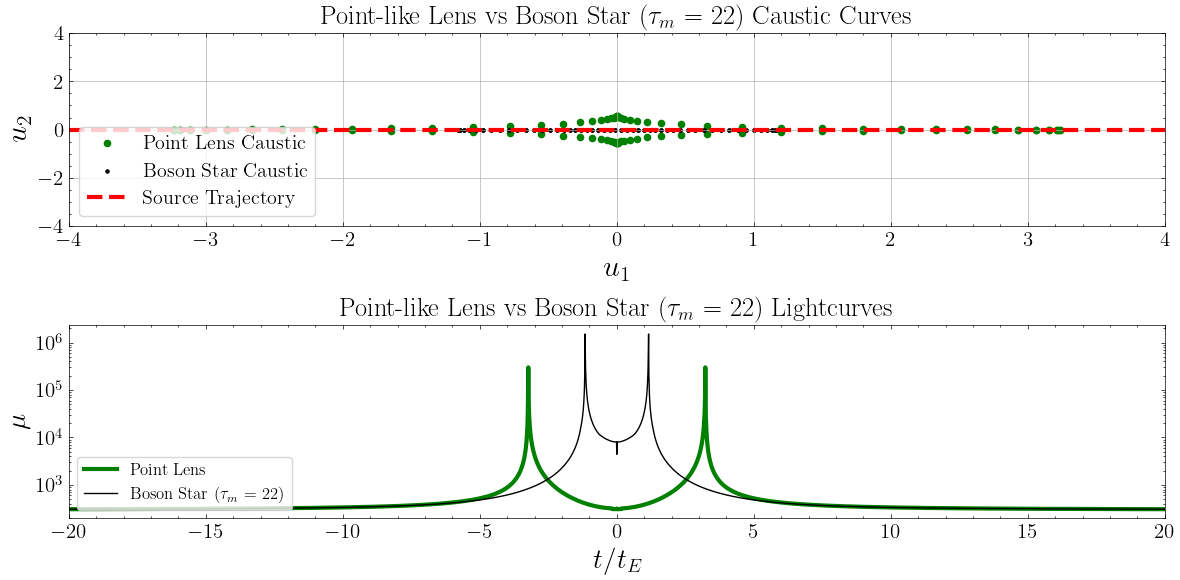

In [289]:
#Plot the lightcurve and caustic curve with crossing

fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(12, 6))

ax1.plot(timestamps, lightcurve_pl, color='green', label='Point Lens', linewidth = 3)
ax1.plot(timestamps, lightcurve_bs, color='black', label=r'Boson Star ($\tau_m$ = ' + f'{tau_m_val})')
ax1.set_xlabel(r'$t/t_E$', fontsize=20)
ax1.set_xlim(-20,20)
# ax1.set_ylim(100, 1e3)
ax1.set_ylabel(r'$\mu$', fontsize=20)
ax1.set_yscale('log')
ax1.tick_params(axis='both', labelsize=15)
ax1.legend(loc='lower left', fontsize='large', frameon=True)
ax1.set_title(r'Point-like Lens vs Boson Star ($\tau_m$ = ' + f'{tau_m_val}) Lightcurves', fontsize=19)

ax2.scatter(caustic_u1_pl, caustic_u2_pl, color='green', s=20, label='Point Lens Caustic')
ax2.scatter(caustic_u1_bs, caustic_u2_bs, color='black', s=5, label='Boson Star Caustic')
ax2.plot(u1_traj, u2_traj, color='red', linewidth=3, linestyle = '--',label="Source Trajectory")
ax2.legend(loc='lower left', fontsize='x-large', frameon=True)
ax2.set_xlabel(r"$u_1$", fontsize=22)
ax2.set_ylabel(r"$u_2$", fontsize=22)
ax2.tick_params(axis='both', labelsize=15)
ax2.set_title(r"Point-like Lens vs Boson Star ($\tau_m$ = " + f'{tau_m_val}) Caustic Curves', fontsize=19)
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4,4)
ax2.grid(True)

plt.tight_layout()
#save figure:
plt.savefig('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/figures/bs_tau_m_22_pl_comparison_top_bottom.png', dpi=300, format='png')

In [287]:
# Save timestamps and lightcurve_bs to a CSV file
df_lightcurve_bs = pd.DataFrame({'timestamps': timestamps, 'magnifications': lightcurve_bs})
df_lightcurve_bs.to_csv('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/lightcurves_and_caustics/lightcurve_bs_tau_m_22.csv', index=False)

# Save timestamps and lightcurve_pl to a CSV file
df_lightcurve_pl = pd.DataFrame({'timestamps': timestamps, 'magnifications': lightcurve_pl})
df_lightcurve_pl.to_csv('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/lightcurves_and_caustics/lightcurve_pl.csv', index=False)

# # Save caustic_u1_pl and caustic_u2_pl to a CSV file
# df_caustic_pl = pd.DataFrame({'u1': caustic_u1_pl, 'u2': caustic_u2_pl})
# df_caustic_pl.to_csv('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/lightcurves_and_caustics/caustic_curve_pl.csv', index=False)

# # Save caustic_u1_bs and caustic_u2_bs to a CSV file
# df_caustic_bs = pd.DataFrame({'u1': caustic_u1_bs, 'u2': caustic_u2_bs})
# df_caustic_bs.to_csv('/home/bcrossey/Documents/Microlensing/Code/Microcaustics_EDOs/lightcurves_and_caustics/caustic_curve_bs_tau_m_20.csv', index=False)